# General Sequence-to-Sequence Mappings

Many times, we want to map an arbitrary length sequence to another arbitrary length sequence for a machine learning task. The most common example would be for machine translation where the number of characters/words used to encode a sentence in one language rarely matches with the number of characters/works used to encode a sentence with the same meaning in another language. Thus, the many-to-many mapping used by the simple recurrent network used in the previous example will not be approprite.

In order to accomplish this task, the most common architecture used at this time is the *encoder-decoder* framework. First, we build an *encoder* network which takes an arbitrary length input sequence, and encodes a distributed representation of that input sequence using the hidden layer of a recurrent network. This is similar to a standard many-to-many recurrent network, except there is no output layer for the encoder. Instead, the input sequence information is simply folded into the hidden layer activation pattern at each time step. Once the encoder finishes generating a *gestalt* representation of the input sequence (using a recurrent hidden layer), the hidden layer activations are fed into a *decoder* network which translates the *gestalt* representation into the corresponding output sequence using another recurrent hidden layer and time-distributed output layer. Special *start* and *stop* patterns are used to encode for the starting and ending points of target sequences during training, so the *decoder* network learns to indicate when it is ready to start and finish a particular output sequence. Using its two subnetworks, the encoder-decoder framework forms a general sequence-to-sequence learning framework.

In order to illustrate how to build and train an encoder-decoder network, we will utilize the parity task from the simple recurrent network example. Even though the sequence lengths are the same for both the input and output for this task, we can still utilize it to illustrate the core concepts involved. Also, we will be using long short-term memory for the recurrent layers of these networks to show their effectiveness at learning these kinds of tasks.

In [3]:
# Import what we need for the job...
import keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras_tqdm import TQDMNotebookCallback

# Visualization
from IPython.display import SVG, HTML
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [4]:
# Hack to fix TQDM extra lines issue...
# Reference: https://github.com/bstriner/keras-tqdm/issues/21
from keras_tqdm import TQDMNotebookCallback
display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

Let's create the parity problem again, but we need to encode the input and target sequences a bit more generically this time to show how the process might be generalized to other types of sequence processing domains.

One key idea is that we need to map our possible sequence elements into a one-hot encoding dictionary which will be useful for arbitray sequence specification for both the encoder and decoder parts of the network. We will use the following mapping:

Input Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `10` |
| `1` | `01` |

Ouput Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `1000` |
| `1` | `0100` |
| start | `0010` |
| stop  | `0001` |

This encoding will necessarily make the problem easier to solve (0 is now mapped to a meaningful orthogonal dimension to the other symbols), but more importantly, it shows how each symbol in the input/output sequences needs an orthogonal dimension in the encoded form. Other distributed codes may also work, but high dot product similarity between vectors in the encoding chosen may affect the network's learning capabilities in unpredictable ways (more than likely negative). Also, it should be clear here that we don't even need to have the same *symbols* in the encoder and decoder networks. They can be arbitrary mappings in both time and space, which makes this a powerful, flexible approach.

OK, so let's generate a large set of training and testing sequences for the network to experience on this task...

In [5]:
# Length of sequences to model
length = 10

# Note we are making these the same, but they don't -have- to be!
input_length = length
output_length = length

As a good rule of thumb, we just want to create a network and train it to learn just a single example first. After that, we can extend it to a larger data set.

In [6]:
# Generate a random string of 0s and 1s
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.]]])

In [7]:
# Calculate parity (note this is the same algorithmic approach
# that we are trying to encourage our net to learn!)
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
    # Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [8]:
y_train = parity(x_train[0,:,:])
y_train

array([[[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]]])

Let's turn these into a set of encoded input-output vectors using the transformation above.

In [9]:
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]),axis=0)
X

array([[[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]]], dtype=float32)

In [10]:
Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
                   np.hstack([keras.utils.to_categorical(y_train[0,:,0]),np.zeros([output_length,2])]),
                   np.array([0,0,0,1])]),axis=0)
Y

array([[[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

Also, note the shapes of the sequences...

In [11]:
X.shape

(1, 10, 2)

In [12]:
Y.shape

(1, 12, 4)

We will need to divide the target data into two groups which correspond to the input-target pairs for the *decoder* network. In essence, the decoder network is really just a many-to-many recurrent network, and will be trying to predict the next part of the target sequence (`postY`) given *both* the encoder output representation *and* the previous target sequence entry (`preY`). This previous target sequence entry is not strictly necessary, but using it represents a training strategy called *teacher forcing* which makes it easier to learn some sequences.

In [13]:
# 12 time steps total (10 + start + stop)
# Divide into two groups of 11
# First from 0 ... 10
preY = Y[:,0:output_length+1,:]
# Second from 1 ... 11
postY = Y[:,1:output_length+2,:]

In [14]:
preY.shape

(1, 11, 4)

In [15]:
postY.shape

(1, 11, 4)

OK, let's make an encoder-decoder framework for learning this sequence. We need to use the Keras *functional* API for building this network as well. To create networks of this kind, we first create `layer` objects and then call their `()` functions to make them take inputs from the provided layers' outputs. This allows for networks to receieve input from more than one layer at a time, or pass their outputs to more than one layer at a time. Once all of the layers have been connected in the desired ways, then we create a `Model` object which is provided a set of input and output layers for the overall model. This allows for more general network topologies to be constructed than can be achieved with the *sequential* API.

Generally, the process looks like so:
1. mylayer = Layer(...)
2. mylayer_output(s) = mylayer(input_layer(s))

Outputs from a layer may be passed as inputs to other layers for chaining layers together...

In [16]:
# Size of the gestalt, context representations...
hidden_size = input_length*2

## Encoder Construction

# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]

## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 20), (None,  1840        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 20), ( 2000        input_2[0][0]                    
                                                                 lstm_1[0][1]               

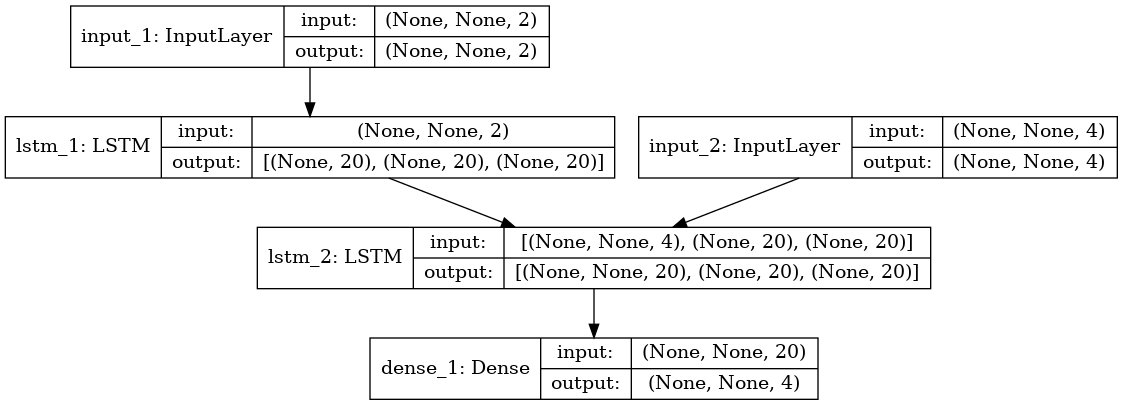

In [17]:
# Visualization - wish we could see the recurrent weights!
plot_model(model,to_file='combined-encdec.png',show_shapes=True,expand_nested=True)

So, these visualizations are a little helpful now, maybe? Well, again, the recurrent connection weights are stored in the LSTM layers, so there is little information there. However, it is clear how the *teacher forcing* layer (second input layer) is connected in and provides a little more support to the learning. We will feed the output from the final dense layer back into this layer when performing prediction below as well once it has learned the sequence properly.

In [18]:
batch_size = 1   # only one pattern...
epochs = 200
history = model.fit([X,preY], postY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


1/1 [==============================] - 0s 204ms/step
Accuracy: 100.0 %


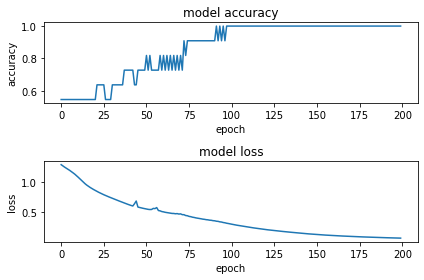

In [20]:
plt.figure(1)  
# summarize history for accuracy 
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.tight_layout()
plt.show()  

The network appears to have learned the sequence, but there is one thing wrong with the final evaluation: the *teacher forcing* inputs are still bein provided on each time step. Instead, we should be feeding the *output* from the decoder back into this input layer, so that it can use *it's own predictions* to forecast the next step. If we had left off the teacher forcing inputs entirely, this would not have been necessary, but let's make a more proper test of the network now.

In order to accomplish this part of the job, we will construct *another* model, but just use the layers already defined and trained before. This will allow us to connect the layers together to create a model which accomplishes the feedback loop for us...

In [21]:
# Part 1 - make the encoder

# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder

# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

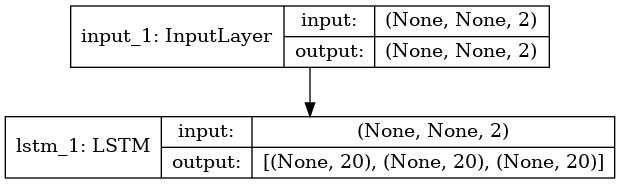

In [22]:
# Show the separated encoder model
plot_model(encoder_model,to_file='encoder.png',show_shapes=True,expand_nested=True)

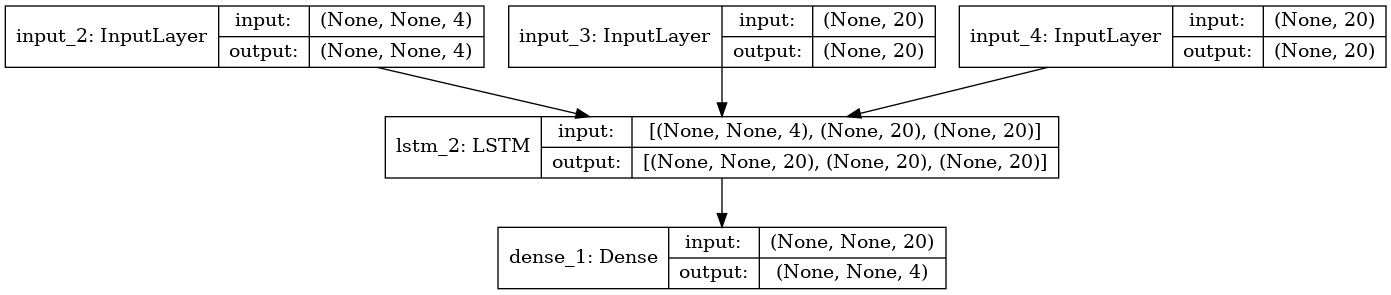

In [23]:
# Show the separated decoder model
plot_model(decoder_model,to_file='decoder.png',show_shapes=True,expand_nested=True)

OK, at this point, it's important that we slow down and think about what we just constructed here. This network is not going to be *trained* in any way, and it (mostly) just reuses layers that have already created (*and* trained) in the earlier part of this example. Therefore, we are just going to rearrange some of the layers into *two* new models to make it easier to probe the network. These parts will naturally be the encoder and the decoder. However, these new models will just be used for *prediction* instead of training.

The basic idea is that we need to *first* encode the input sequence into its *gestalt* context representation. This is the job of the encoder, and this part is rather straight-forward because the encoder network architecture remains practically unchanged: we just didn't give the encoder it's own, independent model before. Therefore, we could *not* just extract a hidden layer representation without also feeding it into the input layer of the decoder. The new `encoder_model` now just takes our input sequence and provides us with the output "states" or *activations* of the LSTM units. We can use the `predict()` method now to easily obtain those representations.

The second part of the decoding process involves making a new set of inputs for the decoder which will accept the state information from the encoder outputs (in addition to the sequence starting token). This uses two layers which are just standard input layers set to the corresponding size of the LSTM outputs from the encoder. This just allows us to transfer that information over to the decoder *manually* by copying the output values from the encoder into these input layers. The hidden layer of the decoder then takes the encoder's hidden layer information and an input token vector (decoder_input, just like before).

Instead of using teacher forcing to make the sequence input equal to a prescribed target token (like we did during training), here we will only provide the *start* token along with the encoder's gestalt context. After that, we will let the decoder produce an output value. This output value will then be rounded to the nearest value (it's a graded prediction, so we clean it up a little in this obvious way), and then we will feed it *back* into the decoder for the next time step (along with the updated decoder hidden layer activations as well which take the place of the encoder network's initial context information). So long as we provide the encoder's activations and the *start* token on the first step. The decoder network is then asked to step through this series of steps repeatedly until it reaches the *stop* token (or a maximum number of steps is reached). In our case, all sequences are of the same length, so we will expect it will reach the stop token by the 11th output.

Let's walk through these steps by calculating the context from the encoder using our input sequence, `X`, then providing the *start* token (`0010`) to the encoder output as the first inputs to the decoder. Then we will recycle the decoder's output and hidden representations back into the network, just predicting one time step at a time until the sequence terminates.

In [24]:
# Get the gestalt context for the input sequence(s)
context = encoder_model.predict(X)

# Prep a starting token [[[0,0,1,0]]]..
token = np.zeros([1,1,Y.shape[2]])
token[0,0,2] = 1
token

array([[[0., 0., 1., 0.]]])

In [25]:
# Complete 11 cycles with the decoder
result = np.zeros(postY.shape)
for x in range(output_length+1):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
result

array([[[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [26]:
# Let's compare with the pattern
postY

array([[[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

And we have a match! Looks like the encoder-decoder had no trouble learning the sequence. Note that we could wait for the *stop* token instead of counting the number of steps above and we would have come to the same result since that token was encountered on the last iteration. That is, the network learns to generate the right size sequence when required.

OK, so now, let's take the same approach as we used above to learn a large number of sequences...

In [27]:
# New length
length = 10
input_length = length
output_length = length

# Set number of patterns here
n_seq = 100

# Generate the Xs
x_train = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for x in range(n_seq)])
y_train = np.concatenate([parity(x_train[x,:,:]) for x in range(n_seq)])

# Reformat - dictionary approach
X = np.concatenate([np.expand_dims(keras.utils.to_categorical(x_train[x,:,:]),axis=0) for x in range(n_seq)])
Y = np.concatenate([np.expand_dims(np.vstack([np.array([0,0,1,0]),
                                   np.hstack([keras.utils.to_categorical(y_train[x,:,:]),np.zeros([output_length,2])]),
                                   np.array([0,0,0,1])]),axis=0) for x in range(n_seq)])
preY = Y[:,0:length+1,:]
postY = Y[:,1:length+2,:]

In [28]:
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(100, 10, 2)
(100, 12, 4)
(100, 11, 4)
(100, 11, 4)


In [29]:
# Same as before...

# Size of the gestalt, context representations...
hidden_size = input_length*2

## Encoder Construction

# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]

## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 20), (None,  1840        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 20), ( 2000        input_6[0][0]                    
                                                                 lstm_3[0][1]               

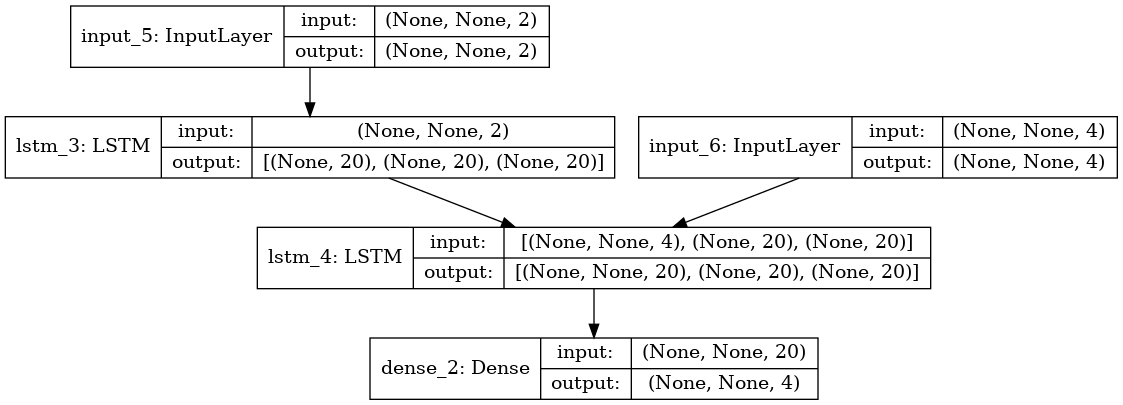

In [30]:
# Visualization - wish we could see the recurrent weights!
plot_model(model,to_file='enc-dec.png',show_shapes=True,expand_nested=True)

In [31]:
batch_size = 20   # many patterns...
epochs = 1500
history = model.fit([X,preY], postY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[TQDMNotebookCallback()],
          validation_split = 0.2) # Remember, teacher forced, but a little informative...
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


100/100 [==============================] - 0s 206us/step
Accuracy: 95.90908885002136 %


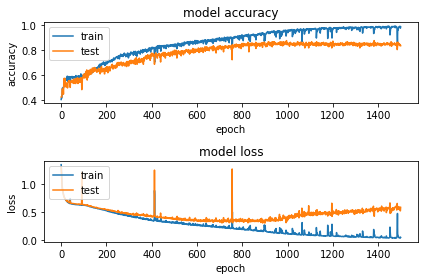

In [32]:
plt.figure(1)
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()  

In [33]:
## Testing!

# Part 1 - make the encoder

# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder

# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

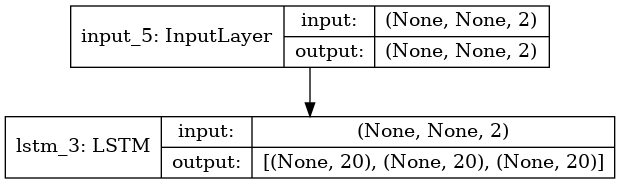

In [34]:
# Show the separated encoder model
plot_model(encoder_model,to_file='encoder2.png',show_shapes=True,expand_nested=True)

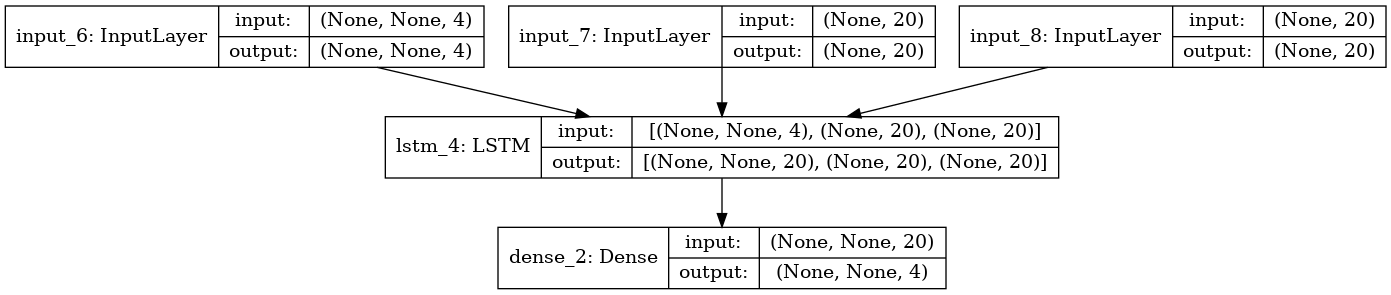

In [35]:
# Show the separated encoder model
plot_model(decoder_model,to_file='decoder2.png',show_shapes=True,expand_nested=True)

In [36]:
# Testing time...
error = 0
for p in range(n_seq):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[p:p+1,:,:])

    # Prep a starting token [[[0,0,1,0]]]..
    token = np.zeros([1,1,Y.shape[2]])
    token[0,0,2] = 1
    token

    # Complete 11 cycles with the decoder
    result = np.zeros(postY.shape)
    for x in range(output_length+1):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    error += np.sum(np.abs(result-postY[p:p+1,:,:]))/2.0

In [37]:
print("Overall accuracy: %f%%"%(100.0 - (error / (n_seq*output_length))))

Overall accuracy: 94.900000%


For the final accuracy calculation, we loop through all of the training patterns and count up all of the missed tokens. This can be expressed as the absolute difference between the predicted output sequence, and the one from the `postY` pattern set (divided by two). The accuracy therefore isn't really how many sequences were correctly classified, but how many tokens the network missed. At this point, then encoder-decoder has made it to about 90% accuracy on all tokens, so with a little more training (or tweaks to the architecture), we might get even further. For example, we could change the activation function from `tanh` (the default for LSTM) to `relu`, try adding more units to the hidden layers, or just stack some additional LSTM layers onto the encoder or decoder networks. 